# Fire AI - DL Models Trial

### Import Libraries

In [ ]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import json
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate, ZeroPadding2D


### Load Dataset

In [ ]:
file_path = 'data/dataset.json'
df = pd.read_json(file_path)
print(df.head())

  date_generated                                               data
0     2024-03-24  {'id': '78a81cb9-e87e-4799-90fb-ef7d2a92be8f',...
1     2024-03-24  {'id': '55403f4e-9722-42b7-bed3-11d18514e012',...
2     2024-03-24  {'id': '9c611343-eeb9-4804-b7ac-c6a54931c73d',...
3     2024-03-24  {'id': '4891427b-0339-4405-b51d-e7d53dbb0e21',...
4     2024-03-24  {'id': '31ff0ffb-c94b-4dd5-9e67-cb8c590d5c6d',...


In [ ]:
# Deconstruct data column into separate dataframe
df = pd.json_normalize(df['data'])
print(df.head())

                                     id  \
0  78a81cb9-e87e-4799-90fb-ef7d2a92be8f   
1  55403f4e-9722-42b7-bed3-11d18514e012   
2  9c611343-eeb9-4804-b7ac-c6a54931c73d   
3  4891427b-0339-4405-b51d-e7d53dbb0e21   
4  31ff0ffb-c94b-4dd5-9e67-cb8c590d5c6d   

                                                room  \
0  [[0, 0], [9357, 0], [9357, 6552], [6738, 6552]...   
1  [[0, 10034], [0, 0], [7067, 0], [7067, 1351], ...   
2  [[7492, 0], [7492, 3334], [8615, 3334], [8615,...   
3  [[9428, 0], [9428, 5241], [9233, 5241], [9233,...   
4  [[9643, 0], [9643, 6587], [8624, 6587], [8624,...   

                                       extinguishers  comply  
0                                [[8702.25, 6552.0]]       1  
1  [[12991.416666666668, 1351.0], [5249.0, 7140.8...       1  
2  [[5886.571428571428, 0.0], [0.0, 4564.8], [695...       1  
3  [[2713.75, 8226.0], [0.0, 3598.875], [1628.25,...       1  
4  [[3750.055555555555, 0.0], [0.0, 5952.57142857...       1  


### Grid Creation

In [ ]:
# Calculate max width and height across all rooms
max_width = 0
max_height = 0
for room in df['room']:
    xs, ys = zip(*room)
    width = max(xs) - min(xs)
    height = max(ys) - min(ys)
    max_width = max(max_width, width)
    max_height = max(max_height, height)

# Define maximum grid size as 200 x 200 grid for now
max_grid_size = 200

# Calculate aspect ratio
aspect_ratio = max_width / max_height

# Adjust grid size to maintain aspect ratio
if aspect_ratio > 1:
    grid_width = max_grid_size
    grid_height = int(max_grid_size / aspect_ratio)
else:
    grid_height = max_grid_size
    grid_width = int(max_grid_size * aspect_ratio)

grid_size = [grid_width, grid_height]
print(f"Proposed grid size: {grid_size}")

Proposed grid size: [200, 141]


In [ ]:
def generate_grids(room_coords, ext_coords, grid_size):
    """
    Generates binary grid representations for room and extinguishers.

    Args:
    - room_coords: Nested list representing the vertices of the room polygon.
    - extinguisher_coords: Nested list representing the positions of extinguishers.
    - grid_size: List indicating the size of the output grid.

    Returns:
    - room_grid: A binary grid where 1s represent the room area.
    - ext_grid: A binary grid where 1s represent the extinguisher positions.

    """
    # Initialize grids
    room_grid = np.zeros(grid_size)
    ext_grid = np.zeros(grid_size)

    # Create a polygon for the room
    room_polygon = Polygon(room_coords)

    # Calculate the bounds of the room to scale coordinates
    min_x, min_y, max_x, max_y = room_polygon.bounds
    scale_x, scale_y = (max_x - min_x)/grid_size[0],(max_y - min_y)/grid_size[1]

    # Fill in room coordinates into grid
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            x, y = min_x + i * scale_x, min_y + j * scale_y
            if room_polygon.contains(Point(x, y)):
                room_grid[i, j] = 1

    # Place extinguishers on the grid
    for x, y in ext_coords:
        i, j = int((x - min_x)/scale_x), int((y - min_y)/scale_y)
        if 0 <= i < grid_size[0] and 0 <= j < grid_size[1]:
            ext_grid[i, j] = 1

    return room_grid, ext_grid

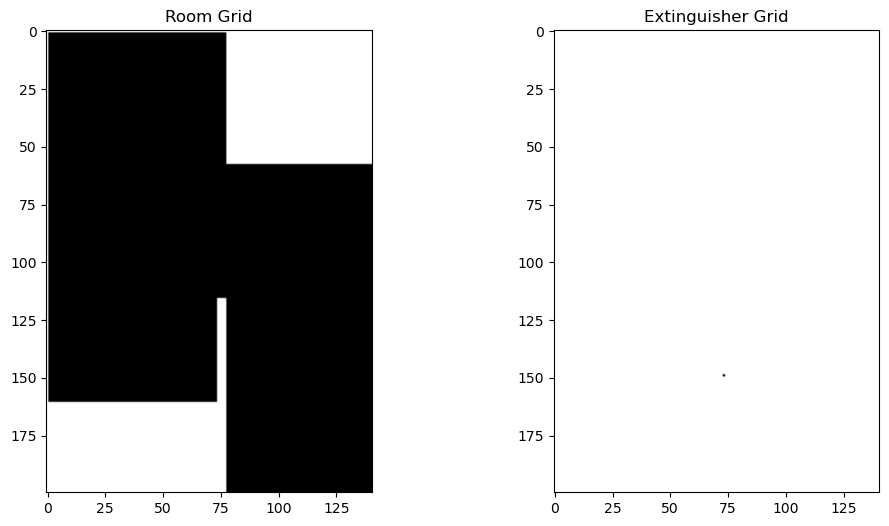

In [ ]:
# Visualise room grid plot with sample_code

room_coords_example = [[0, 0], [9357, 0], [9357, 6552], [6738, 6552], [6738, 6892], [11655, 6892], [11655, 12592], [3369, 12592], [3369, 6892], [0, 6892]]

ext_coords_example = [[8702.25, 6552.0]]

room_grid, ext_grid = generate_grids(room_coords_example, ext_coords_example, grid_size)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Room Grid")
plt.imshow(room_grid, cmap='binary')

plt.subplot(1, 2, 2)
plt.title("Extinguisher Grid")
plt.imshow(ext_grid, cmap='binary')
plt.show()

### Data Preparation

In [ ]:
from joblib import Parallel, delayed

In [ ]:
# Filter for compliant configurations
compliant_df = df[df['comply'] == 1]

num_samples = len(compliant_df)

# Adjust dimensions based on calculated grid size
X = np.zeros((num_samples, grid_width, grid_height, 1)) # Inputs: Room config
Y = np.zeros((num_samples, grid_width, grid_height, 1)) # Targets: Extinguisher placement

def get_sample_data(index, compliant_df):
    """
    Retrieve room and extinguisher coordinates for a given index in filtered dataframe
    """
    sample = compliant_df.iloc[index]
    return sample['room'], sample['extinguishers']

# Apply adjusted grid size to each sample
def process_sample(i):
    room_coords, extinguisher_coords = get_sample_data(i, compliant_df)
    room_grid, extinguisher_grid = generate_grids(room_coords, extinguisher_coords, grid_size)
    return room_grid, extinguisher_grid

# Parallel processing
results = Parallel(n_jobs=-1)(delayed(process_sample)(i) for i in range(num_samples))

for i, (room_grid, extinguisher_grid) in enumerate(results):
    X[i, :, :, 0] = room_grid
    Y[i, :, :, 0] = extinguisher_grid

### CNN Model Definition

In [ ]:
# For later refinement

def build_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'),
        Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same'),
        ZeroPadding2D(padding=((0, 0), (1, 0))),
        Conv2D(1, (3, 3), activation='sigmoid', padding='same')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model((grid_height, grid_width, 1))

print(model.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 141, 200, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 70, 100, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 70, 100, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 35, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_16             │ (None, 70, 100, 64)    │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_17             │ (None, 140, 200, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_3                │ (None, 140, 201, 32)   │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 140, 201, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

None


### Training Model

In [ ]:
model.fit(X, Y, epochs=10, validation_split=0.2, batch_size=32)

Epoch 1/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 72s 348ms/step - accuracy: 0.9871 - loss: 0.1130 - val_accuracy: 0.9999 - val_loss: 0.0014
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 76s 374ms/step - accuracy: 0.9999 - loss: 0.0012 - val_accuracy: 0.9999 - val_loss: 7.2015e-04
Epoch 3/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 78s 381ms/step - accuracy: 0.9999 - loss: 6.8486e-04 - val_accuracy: 0.9999 - val_loss: 5.5677e-04
Epoch 4/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 77s 378ms/step - accuracy: 0.9999 - loss: 5.6060e-04 - val_accuracy: 0.9999 - val_loss: 4.8677e-04
Epoch 5/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 79s 386ms/step - accuracy: 0.9999 - loss: 4.8870e-04 - val_accuracy: 0.9999 - val_loss: 4.4760e-04
Epoch 6/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 77s 378ms/step - accuracy: 0.9999 - loss: 4.5231e-04 - val_accuracy: 0.9999 - val_loss: 4.2225e-04
Epoch 7/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 77s 375ms/step - accuracy: 0.9999 - loss: 4.3104e-04 - val_accuracy: 0.9999 - val_loss: 4.0611e-04
Epoch 8/10
204/204 ━━━━━━━━━━━━━━━━━━━━

### Predictions

In [ ]:
# Processing new room grid

def generate_new_room_grid(room_coords, grid_size):
    """
    Generates binary grid representations for room based on new room coordinates/ vertices.

    Args:
    - room_coords: Nested list representing the vertices of the room polygon.
    - grid_size: List indicating the size of the output grid.

    Returns:
    - room_grid: A binary grid where 1s represent the room area.

    """
    # Initialize grids
    room_grid = np.zeros(grid_size)

    # Create a polygon for the room
    room_polygon = Polygon(room_coords)

    # Calculate the bounds of the room to scale coordinates
    min_x, min_y, max_x, max_y = room_polygon.bounds
    scale_x, scale_y = (max_x - min_x)/grid_size[0],(max_y - min_y)/grid_size[1]

    # Fill in room coordinates into grid
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            x, y = min_x + i * scale_x, min_y + j * scale_y
            if room_polygon.contains(Point(x, y)):
                room_grid[i, j] = 1

    return room_grid

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[[[[1.91827025e-03]
   [4.15487702e-05]
   [7.25085420e-06]
   ...
   [6.73137151e-07]
   [1.00348973e-06]
   [7.39361509e-04]]

  [[1.89492523e-04]
   [1.99275675e-07]
   [3.10299941e-09]
   ...
   [8.81002771e-10]
   [1.49590118e-08]
   [2.02653719e-05]]

  [[4.33530513e-05]
   [5.29807131e-08]
   [8.08051237e-10]
   ...
   [3.13681725e-09]
   [1.70545249e-08]
   [1.35897708e-05]]

  ...

  [[5.03564434e-06]
   [8.53897175e-10]
   [1.01847406e-10]
   ...
   [4.47985883e-07]
   [1.81630583e-07]
   [2.15554610e-06]]

  [[1.22240408e-05]
   [1.47011052e-08]
   [9.29446387e-09]
   ...
   [4.43035105e-06]
   [3.11012013e-06]
   [2.44985567e-05]]

  [[1.49313593e-03]
   [1.45238391e-05]
   [1.67749499e-06]
   ...
   [5.53985155e-05]
   [6.96030984e-05]
   [2.07085046e-04]]]]


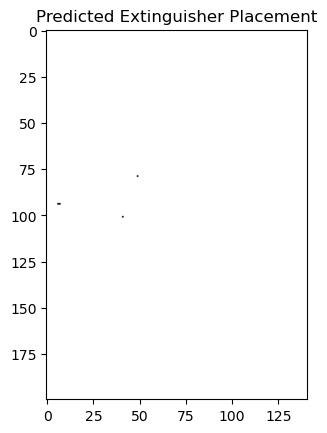

In [ ]:
# Sample room grid
room_coords_example = [[26756, 11800], [16799, 11800], [16799, 11473], [8608, 11473], [8608, 6093], [0, 6093], [0, 0], [8608, 0], [8608, 5077], [26756, 5077]]
new_room_grid = generate_new_room_grid(room_coords_example, grid_size)
room_grid_reshaped = room_grid.reshape(1, grid_size[0], grid_size[1], 1)
predicted_ext_grid = model.predict(room_grid_reshaped)
threshold = 0.01
predicted_ext_grid_binary = (predicted_ext_grid > threshold).astype(int)
print(predicted_ext_grid)

plt.imshow(predicted_ext_grid_binary.reshape(grid_size), cmap='Greys')
plt.title("Predicted Extinguisher Placement")
plt.show()